In [1]:
import os 
import sys

sys.path.append('../methods/')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
path_base = '/home/jinandmaya/perturbseq/'


def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()


# TSNE

In [2]:
counts = pd.read_csv('SCP1184/expression/expression_PertCortex.new.txt', sep='\t', index_col=0)
counts = counts.T

tsne = pd.read_csv('SCP1184/cluster/tsne_PertCortex.txt', sep='\t', index_col=0)
tsne = tsne.iloc[1:, :]  # Remove the first row

metadata = pd.read_csv('SCP1184/metadata/meta_PertCortex.txt', sep='\t')
metadata = metadata.iloc[1:, :]  # Remove the first row
metadata.set_index('NAME', inplace=True)

id_cells = (metadata['isAnalysed']=='TRUE')&(metadata['CellType']=='Excitatory')

perturbations = metadata[id_cells].groupby('Perturbation').filter(lambda x: len(x) > 50)['Perturbation'].unique()
id_cells = id_cells & metadata['Perturbation'].isin(perturbations)
id_cells = id_cells.values

counts = counts[id_cells]
metadata = metadata[id_cells]
tsne = tsne[id_cells]

In [3]:
import scanpy as sc
adata = sc.AnnData(counts.values, obs=metadata, var=pd.DataFrame(index=counts.columns))

adata.obsm['X_tsne'] = tsne.values.astype(float)

from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

adata.write_h5ad("SCP1184/adata.h5ad")

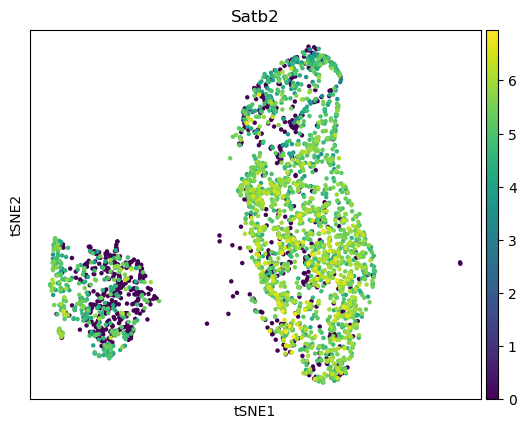

In [4]:
gene_name = 'Satb2'
sc.pl.tsne(adata, color=gene_name)

# Heatmap of batch and treatment assignments

In [5]:
# Read the metadata
metadata = pd.read_csv('SCP1184/metadata/meta_PertCortex.txt', sep='\t')
metadata = metadata.iloc[1:, :]  # Remove the first row
metadata = metadata[metadata['isAnalysed']=='TRUE']
metadata = metadata[metadata['CellType']=='Excitatory']

metadata = metadata.groupby('Perturbation').filter(lambda x: len(x) > 50)
metadata['Batch'] = metadata['Batch'].astype(int)
counts = metadata.groupby(['Batch', 'Perturbation']).size().unstack(fill_value=0)


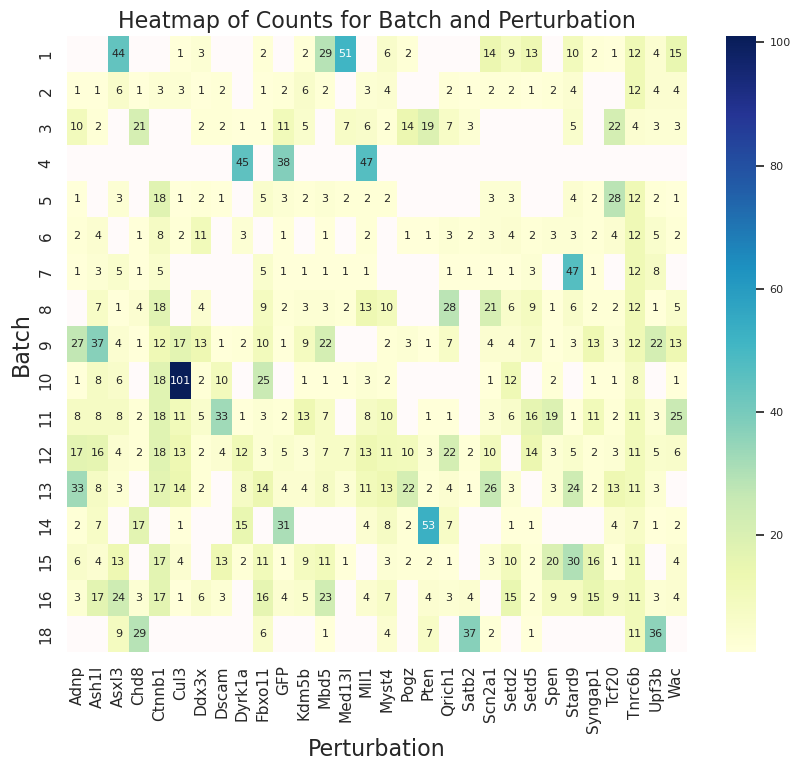

In [6]:
cmap = sns.color_palette("YlGnBu", as_cmap=True)
# cmap.set_under('lightgray')
cmap.set_bad("snow") 
mask = counts == 0
sns.set(font_scale=1.)
# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(counts, annot=True, annot_kws={"size": 8}, fmt="d", cmap=cmap, mask=mask)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

# Set the labels and title
plt.xlabel('Perturbation', fontsize=16)
plt.ylabel('Batch', fontsize=16)
plt.title('Heatmap of Counts for Batch and Perturbation', fontsize=16)

plt.savefig(path_base + 'results/perturbseq_batch.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Number of sample sizes

/tmp/ipykernel_756084/606340592.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perturbation_counts.index, y=perturbation_counts.values, palette='muted')


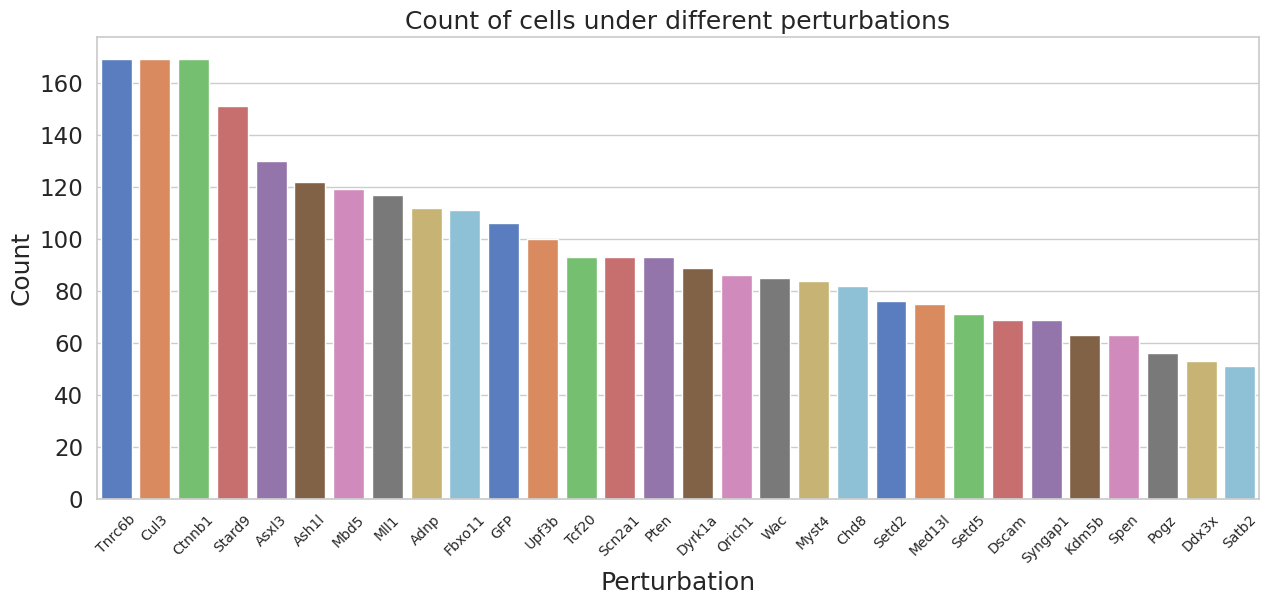

In [7]:
# Get the counts of different values in metadata['Perturbation']
perturbation_counts = metadata['Perturbation'].value_counts()

sns.set(font_scale=1.5, style='whitegrid')
# Create the bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x=perturbation_counts.index, y=perturbation_counts.values, palette='muted')

# Set the labels and title
plt.xlabel('Perturbation')
plt.ylabel('Count')
plt.title('Count of cells under different perturbations')

# Rotate the x-axis tick labels
plt.xticks(rotation=45, fontsize=10)

# Show the plot
plt.savefig(path_base + 'results/count_perturbation.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# Heatmap of discoveries

In [8]:
df = pd.read_csv(path_base+'results/GO/GO.csv', index_col=0)
df['Method'] = df['method'].map({'causarray':'causarray', 'deseq':'DESeq2', 'ruv':'RUV'})

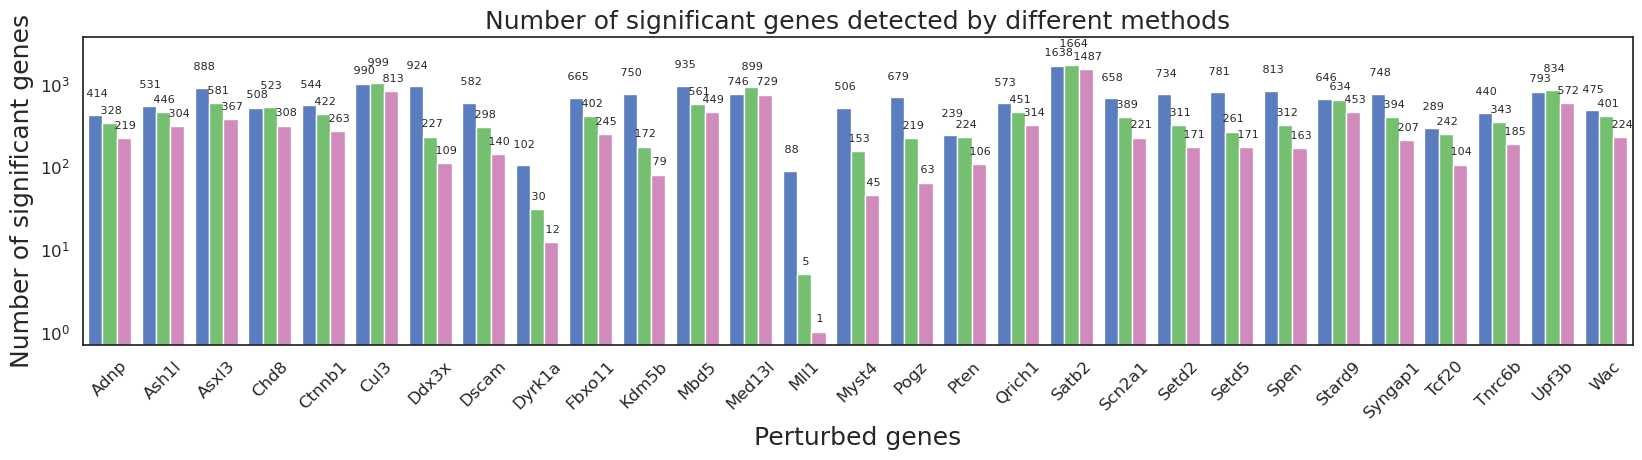

In [9]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(20, 4))
barplot = sns.barplot(data=df, x='trt', y='n_DE_genes', 
    hue='Method', palette = [sns.color_palette("muted")[0], sns.color_palette("muted")[2], sns.color_palette("muted")[6]]
)

n_trt = len(barplot.patches[:-3])//3
for i in range(n_trt):
# for i, p in enumerate(barplot.patches[:-3]):
    if barplot.patches[n_trt+i].get_height() > barplot.patches[i].get_height():
        offsets = [9, 15, 9]
    else:
        offsets = [15, 9, 9]
    for j in range(3):
        p = barplot.patches[i+j*n_trt]

        offset = offsets[j]
        barplot.annotate(format(int(p.get_height()), ' d'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8,
                        xytext=(0, offset),  # 9 points vertical offset
                        textcoords='offset points')

barplot.set_yscale('log')

barplot.legend_.remove()
current_ylim = barplot.get_ylim()
barplot.set_ylim(current_ylim[0], current_ylim[1] * 1.5)
# Set the labels and title
plt.xlabel('Perturbed genes')
plt.ylabel('Number of significant genes')
plt.title('Number of significant genes detected by different methods')

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.savefig(path_base + 'results/perturbseq_DE_genes.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

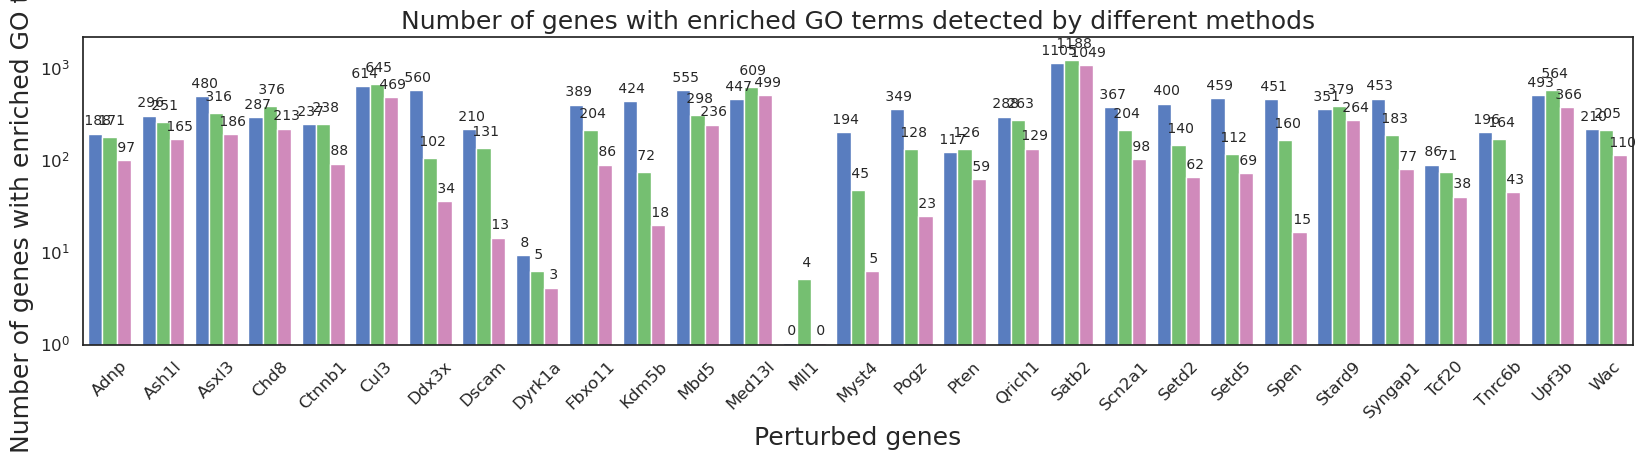

In [10]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(20, 4))
df['n_GO_genes+1'] = df['n_GO_genes'] + 1
barplot = sns.barplot(data=df, x='trt', y='n_GO_genes+1', 
    hue='Method', palette = [sns.color_palette("muted")[0], sns.color_palette("muted")[2], sns.color_palette("muted")[6]]
)

for i, p in enumerate(barplot.patches[:-3]):
    barplot.annotate(format(int(p.get_height()-1), ' d'),
                     (p.get_x() + p.get_width() / 2., p.get_height()*1.1 if len(barplot.patches[:-3])/3<=i<len(barplot.patches[:-3])/3*2 else p.get_height()),
                     ha='center', va='center', fontsize=10,
                     xytext=(0, 9),  # 9 points vertical offset
                     textcoords='offset points')

barplot.set_yscale('log')
current_ylim = barplot.get_ylim()
barplot.set_ylim(current_ylim[0]+0.25, current_ylim[1] * 1.25)
barplot.legend_.remove()

# Set the labels and title
plt.xlabel('Perturbed genes')
plt.ylabel('Number of genes with enriched GO terms')
plt.title('Number of genes with enriched GO terms detected by different methods')

# barplot.axhline(275, color='lightgray', linestyle='--', zorder=-1)




# yticks = barplot.get_yticks()
# yticks = list(yticks) + [275]
# barplot.set_yticks(yticks)
# barplot.set_yticklabels([int(tick) for tick in yticks])

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.savefig(path_base + 'results/perturbseq_GO_genes.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

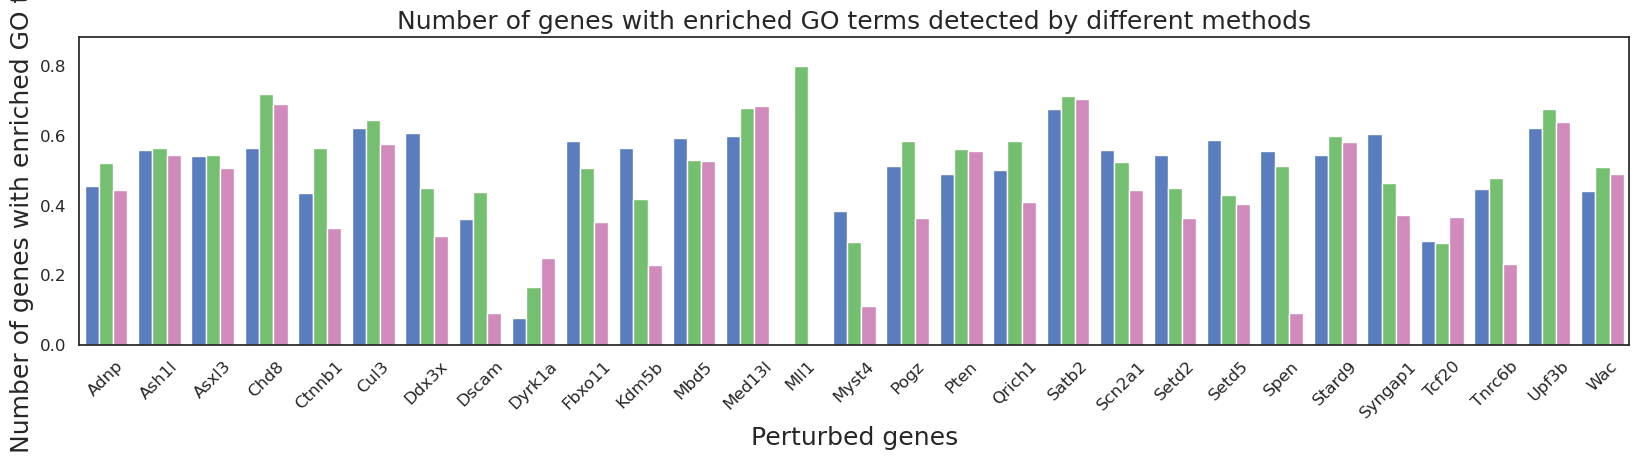

In [11]:
df['ratio_GO_genes']  = df['n_GO_genes'] / df['n_DE_genes']

sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(20, 4))
barplot = sns.barplot(data=df, x='trt', y='ratio_GO_genes', 
    hue='Method', palette = [sns.color_palette("muted")[0], sns.color_palette("muted")[2], sns.color_palette("muted")[6]]
)

# for i, p in enumerate(barplot.patches[:-3]):
#     barplot.annotate(format(int(p.get_height()), ' d'),
#                      (p.get_x() + p.get_width() / 2., p.get_height()+30 if len(barplot.patches[:-3])/3<=i<len(barplot.patches[:-3])/3*2 else p.get_height()),
#                      ha='center', va='center', fontsize=10,
#                      xytext=(0, 9),  # 9 points vertical offset
#                      textcoords='offset points')

current_ylim = barplot.get_ylim()
barplot.set_ylim(current_ylim[0], current_ylim[1] * 1.05)
barplot.legend_.remove()

# Set the labels and title
plt.xlabel('Perturbed genes')
plt.ylabel('Number of genes with enriched GO terms')
plt.title('Number of genes with enriched GO terms detected by different methods')

# barplot.axhline(275, color='lightgray', linestyle='--', zorder=-1)

# yticks = barplot.get_yticks()
# yticks = list(yticks) + [275]
# barplot.set_yticks(yticks)
# barplot.set_yticklabels([int(tick) for tick in yticks])

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
# plt.savefig(path_base + 'results/perturbseq_GO_genes.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

(array([  0., 200., 400., 600., 800.]),
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800')])

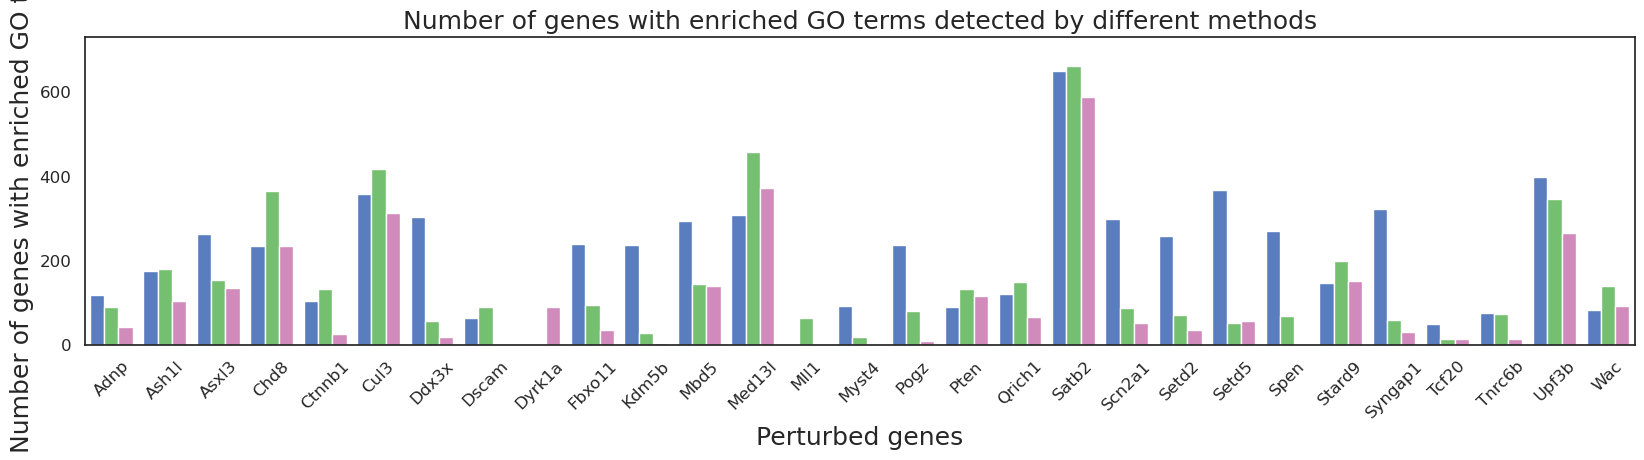

In [12]:
sns.set(style='white', font_scale=1.5)
plt.figure(figsize=(20, 4))
barplot = sns.barplot(data=df, x='trt', y='n_GOs', 
    hue='Method', palette = [sns.color_palette("muted")[0], sns.color_palette("muted")[2], sns.color_palette("muted")[6]]
)

# for i, p in enumerate(barplot.patches[:-3]):
#     barplot.annotate(format(int(p.get_height()), ' d'),
#                      (p.get_x() + p.get_width() / 2., p.get_height()+30 if len(barplot.patches[:-3])/3<=i<len(barplot.patches[:-3])/3*2 else p.get_height()),
#                      ha='center', va='center', fontsize=10,
#                      xytext=(0, 9),  # 9 points vertical offset
#                      textcoords='offset points')

current_ylim = barplot.get_ylim()
barplot.set_ylim(current_ylim[0], current_ylim[1] * 1.05)
barplot.legend_.remove()

# Set the labels and title
plt.xlabel('Perturbed genes')
plt.ylabel('Number of genes with enriched GO terms')
plt.title('Number of genes with enriched GO terms detected by different methods')

# barplot.axhline(275, color='lightgray', linestyle='--', zorder=-1)

# yticks = barplot.get_yticks()
# yticks = list(yticks) + [275]
# barplot.set_yticks(yticks)
# barplot.set_yticklabels([int(tick) for tick in yticks])

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
# plt.savefig(path_base + 'results/perturbseq_GO_genes.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

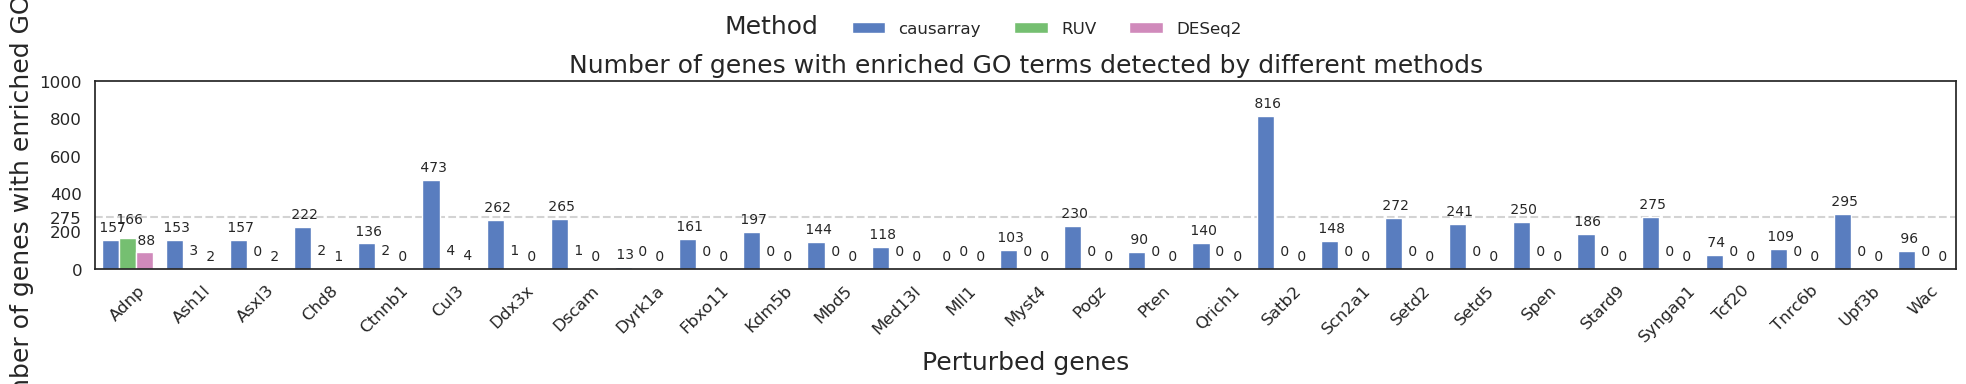

In [13]:
sns.set(style='white', font_scale=1.5)
fig, ax = plt.subplots(1,1,figsize=(20, 4))
barplot = sns.barplot(data=df, x='trt', y='n_GO_genes', 
    hue='Method', palette = [sns.color_palette("muted")[0], sns.color_palette("muted")[2], sns.color_palette("muted")[6]],
    ax=ax
)

for i, p in enumerate(barplot.patches[:-3]):
    barplot.annotate(format(int(p.get_height()), ' d'),
                     (p.get_x() + p.get_width() / 2., p.get_height()+30 if len(barplot.patches[:-3])/3<=i<len(barplot.patches[:-3])/3*2 else p.get_height()),
                     ha='center', va='center', fontsize=10,
                     xytext=(0, 9),  # 9 points vertical offset
                     textcoords='offset points')

current_ylim = barplot.get_ylim()
barplot.set_ylim(current_ylim[0], current_ylim[1] * 1.05)

# Set the labels and title
plt.xlabel('Perturbed genes')
plt.ylabel('Number of genes with enriched GO terms')
plt.title('Number of genes with enriched GO terms detected by different methods')

barplot.axhline(275, color='lightgray', linestyle='--', zorder=-1)

yticks = barplot.get_yticks()
yticks = list(yticks) + [275]
barplot.set_yticks(yticks)
barplot.set_yticklabels([int(tick) for tick in yticks])

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

lines_labels = [ax.get_legend_handles_labels() for ax in [barplot]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
barplot.get_legend().remove()

legend = fig.legend(handles=handles, labels=labels, prop={'size': 12},
                    loc=9, ncol=10, title='Method', frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.8)

# Show the plot
plt.savefig(path_base + 'results/perturbseq_GO_genes_legend.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

# GO terms

In [14]:
# Read the metadata
metadata = pd.read_csv('SCP1184/metadata/meta_PertCortex.txt', sep='\t')
metadata = metadata.iloc[1:, :]  # Remove the first row
metadata = metadata[metadata['isAnalysed']=='TRUE']
metadata = metadata[metadata['CellType']=='Excitatory']

metadata = metadata.groupby('Perturbation').filter(lambda x: len(x) > 50)
metadata['Batch'] = metadata['Batch'].astype(int)

perts = metadata['Perturbation'].unique()

df = pd.DataFrame()
for pert in perts:
    if pert=='GFP':
        continue
    for method in ['causarray','ruv','deseq']:
        _df = pd.read_csv(path_base+'results/GO_terms/{}_GO_{}.csv'.format(pert, method), index_col=0)
        _df['method'] = method
        _df['pert'] = pert
        df = pd.concat([df, _df], axis=0)
df['GeneRatio'] = df['GeneRatio'].apply(lambda x: float(x.split('/')[0]) / float(x.split('/')[1]))

top_descriptions = []
for method in ['causarray', 'ruv']:
    _df = df[df['method'] == method]
    _df.sort_values('GeneRatio', ascending=False, inplace=True)

    description_counts = _df['Description'].value_counts()
    top_descriptions.append(np.array(description_counts.nlargest(20).index))
overlap = np.intersect1d(top_descriptions[0], top_descriptions[1])

/tmp/ipykernel_1073524/543600227.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, _df], axis=0)
/tmp/ipykernel_1073524/543600227.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values('GeneRatio', ascending=False, inplace=True)
/tmp/ipykernel_1073524/543600227.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values('GeneRat

/tmp/ipykernel_1073524/2314846840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values('GeneRatio', ascending=False, inplace=True)
/tmp/ipykernel_1073524/2314846840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values('GeneRatio', ascending=False, inplace=True)


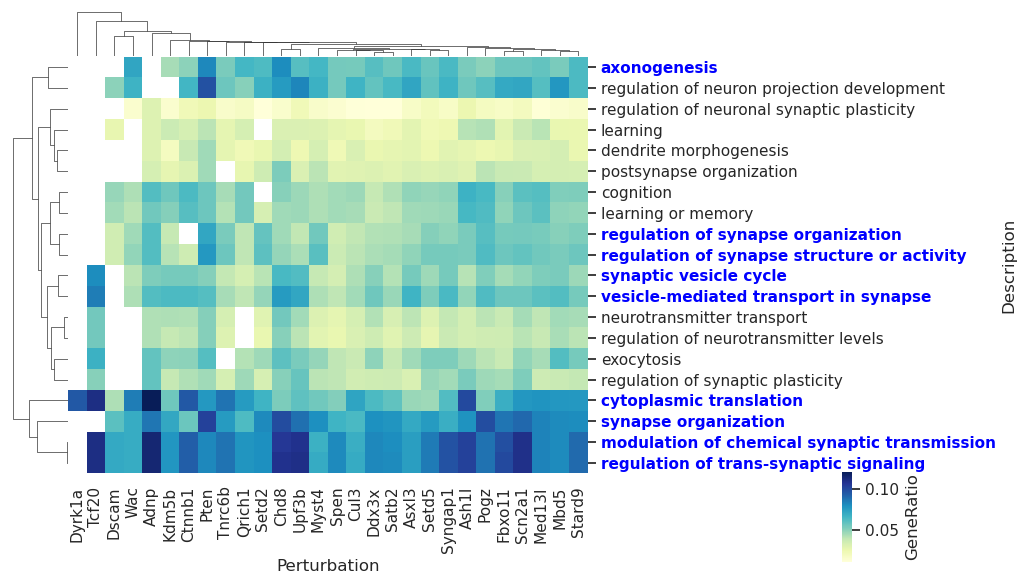

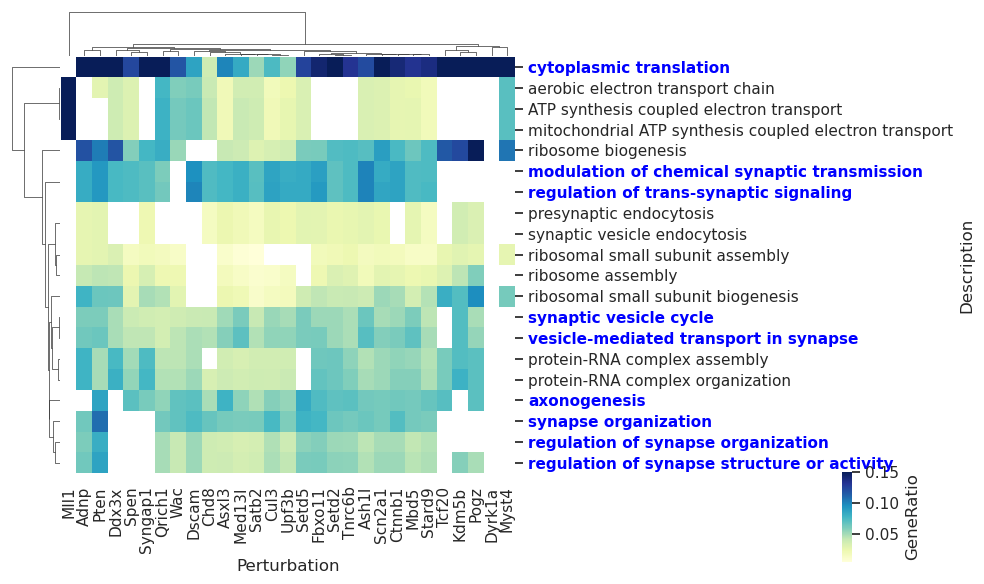

In [15]:
sns.set(style='white', font_scale=1.)
for j,method in enumerate(['causarray','ruv']):
    _df = df[df['method']==method]
    _df.sort_values('GeneRatio', ascending=False, inplace=True)
    _df = _df[_df['Description'].isin(top_descriptions[j])]

    # Pivot the DataFrame to create a 2D matrix for the heatmap
    heatmap_data = _df.pivot(columns='pert', index='Description', values='GeneRatio')
    heatmap_data.fillna(0, inplace=True)
    # heatmap_data = heatmap_data.clip(0,0.25)

    # plt.figure(figsize=(6,20))
    clustermap = sns.clustermap(heatmap_data, #annot=True, 
        cmap='YlGnBu', cbar_kws={'label': 'GeneRatio'}, 
        cbar_pos=(0.85, 0.05, 0.01, 0.15), dendrogram_ratio=(0.1,0.1),
        mask=heatmap_data == 0, #vmax=0.25,
        vmax=.15 if method=='ruv' else None, # for better visualization
        figsize=(10, 6))

    # Set the labels and title
    clustermap.ax_heatmap.set_xlabel('Perturbation')
    clustermap.ax_heatmap.set_ylabel('Description')
    # clustermap.ax_heatmap.set_title('Heatmap of Top 5 GeneRatios for Each Perturbation')

    yticks = clustermap.ax_heatmap.get_yticklabels()
    for tick in yticks:
        if tick.get_text() in overlap:
            tick.set_fontweight('bold')
            tick.set_color('blue')

    # Show the plot
    plt.savefig(path_base + 'results/perturbseq_GO_clustermap_{}.pdf'.format(method), bbox_inches='tight', pad_inches=0, dpi=300)

/tmp/ipykernel_931592/999185365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values('GeneRatio', ascending=False, inplace=True)
/tmp/ipykernel_931592/999185365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values('GeneRatio', ascending=False, inplace=True)


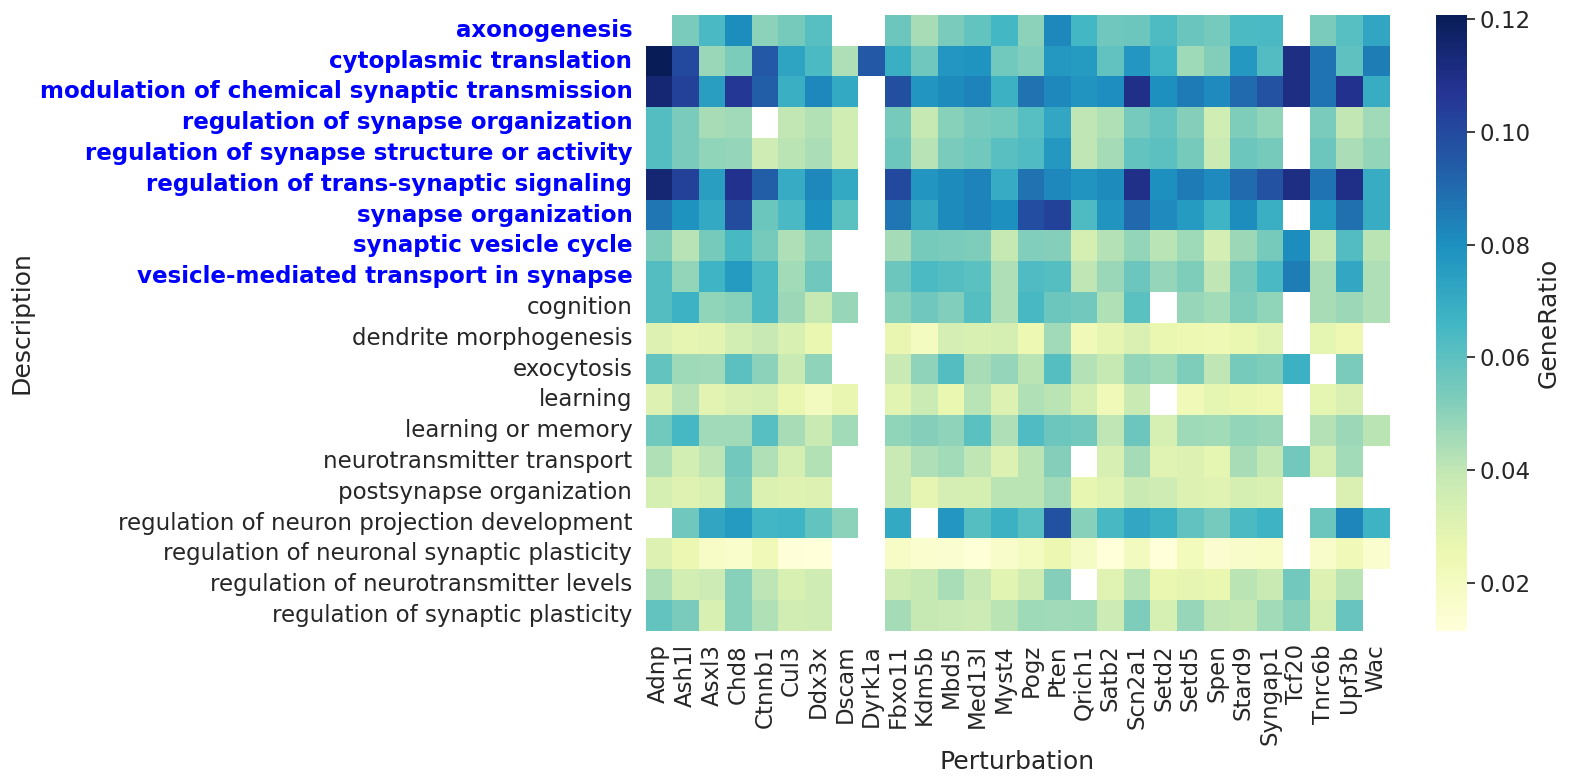

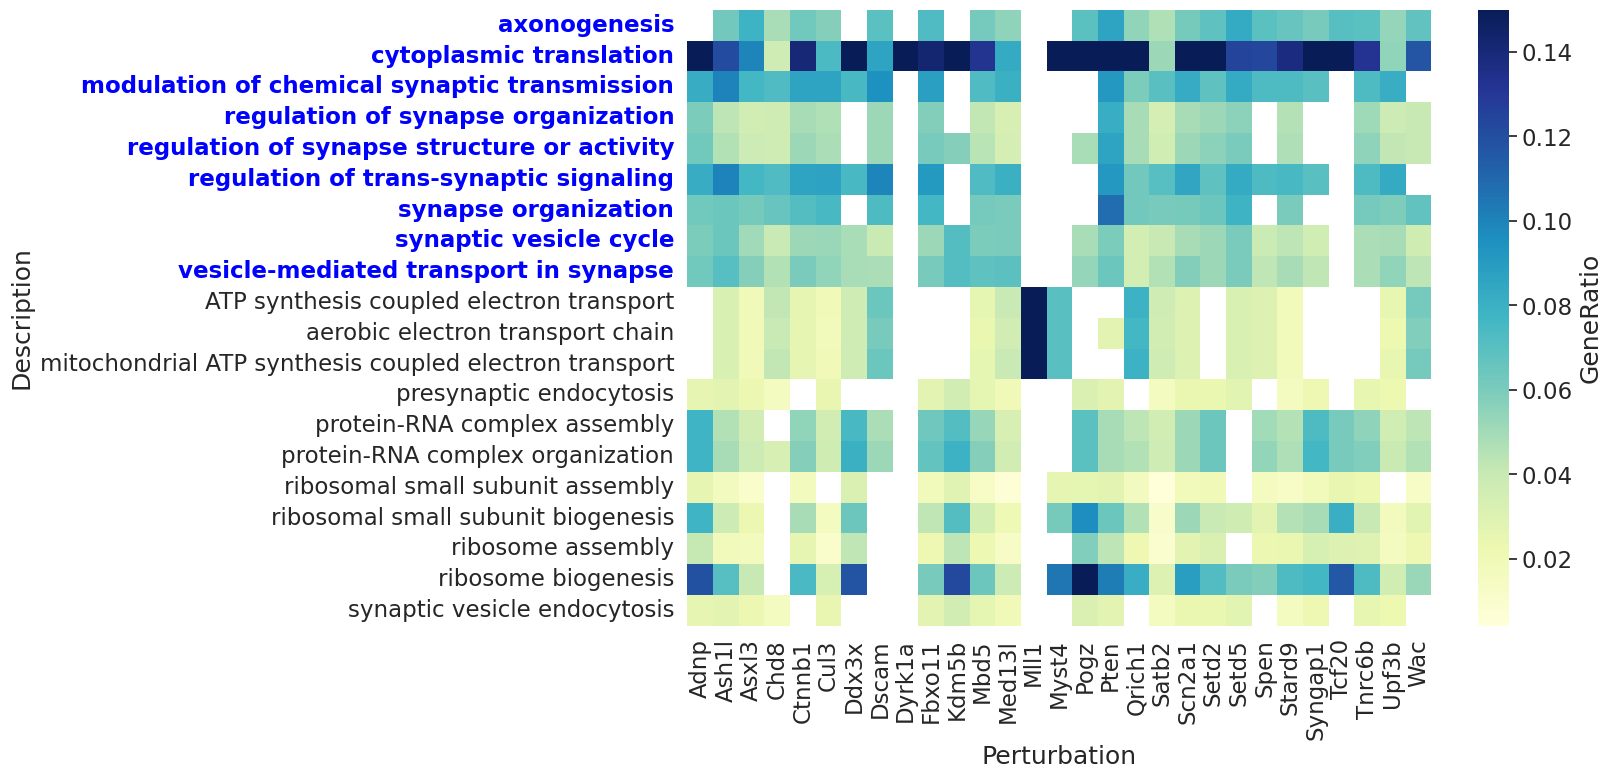

In [16]:
sns.set(style='white', font_scale=1.5)
for j,method in enumerate(['causarray','ruv']):
    _df = df[df['method']==method]
    _df.sort_values('GeneRatio', ascending=False, inplace=True)
    _df = _df[_df['Description'].isin(top_descriptions[j])]


    # Pivot the DataFrame to create a 2D matrix for the heatmap
    heatmap_data = _df.pivot(columns='pert', index='Description', values='GeneRatio')
    heatmap_data.fillna(0, inplace=True)
    # heatmap_data = heatmap_data.clip(0,0.25)
    heatmap_data = pd.concat([
    heatmap_data.loc[overlap],
    heatmap_data[~np.isin(heatmap_data.index, overlap)]], axis=0)

    # Plot the heatmap
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(heatmap_data,
        mask=heatmap_data == 0, vmax=.15 if method=='ruv' else None, # for better visualization
        cmap='YlGnBu', cbar_kws={'label': 'GeneRatio'})


    # Set the labels and title
    ax.set_xlabel('Perturbation')
    ax.set_ylabel('Description')
    # clustermap.ax_heatmap.set_title('Heatmap of Top 5 GeneRatios for Each Perturbation')

    yticks = ax.get_yticklabels()
    for tick in yticks:
        if tick.get_text() in overlap:
            tick.set_fontweight('bold')
            tick.set_color('blue')

    # Show the plot
    plt.savefig(path_base + 'results/perturbseq_GO_heatmap_{}.pdf'.format(method), bbox_inches='tight', pad_inches=0, dpi=300)